In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import os
import pickle

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('StudentsPerformance.csv')

In [3]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


It appears that the race/ethnicity column has letters (A, B, C, etc) instead of actual races and ethnicities. This makes it difficult to draw conclusions about this specific column. 

In [4]:
df.rename(columns = {'parental level of education':'parental_education', 'test preparation course': 'test_prep', 'math score': 'math_score', 'reading score': 'reading_score', 'writing score': 'writing_score'}, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   gender              1000 non-null   object
 1   race/ethnicity      1000 non-null   object
 2   parental_education  1000 non-null   object
 3   lunch               1000 non-null   object
 4   test_prep           1000 non-null   object
 5   math_score          1000 non-null   int64 
 6   reading_score       1000 non-null   int64 
 7   writing_score       1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


'df.info()' lets us know that there are 1000 entries. In each column there are 1000 non-null entries. This is good because it means we have no missing information. Another good thing to note is that there are only three numerical columns: 'math_score', 'reading_score', and 'writing_score'. 

EXPLORATORY DATA ANALYSIS

In [6]:
df.describe()

,math_score,reading_score,writing_score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


All means are less than 70%.
The math mean is the lowest! Reading score mean is the highest!



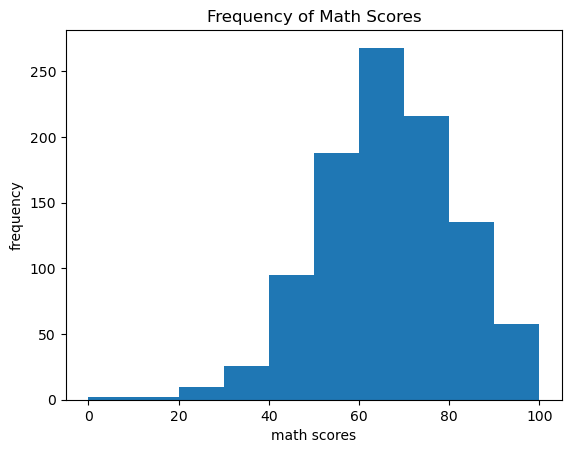

In [7]:
plt.hist(df['math_score'])
plt.xlabel('math scores')
plt.ylabel('frequency')
plt.title('Frequency of Math Scores')
plt.show()

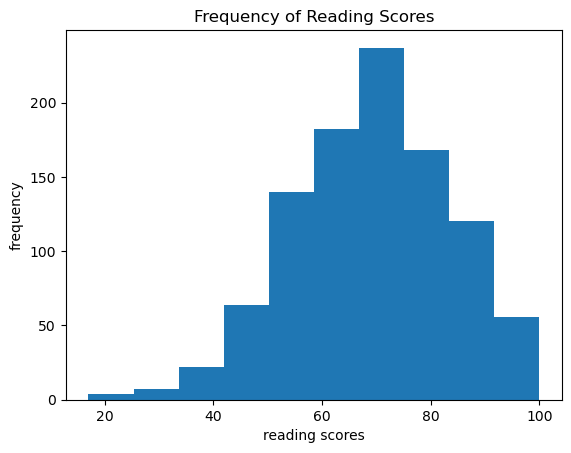

In [8]:
plt.hist(df['reading_score'])
plt.xlabel('reading scores')
plt.ylabel('frequency')
plt.title('Frequency of Reading Scores')
plt.show()

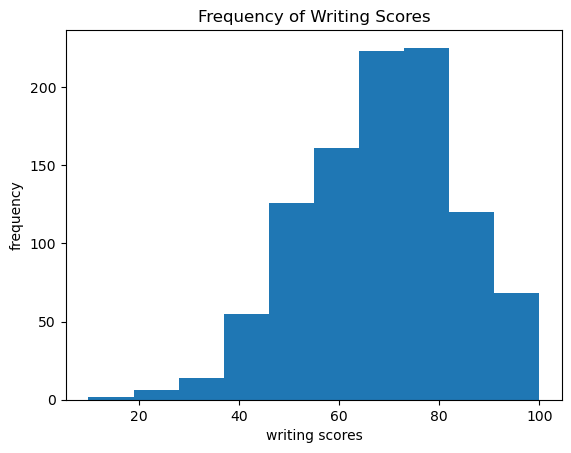

In [9]:
plt.hist(df['writing_score'])
plt.xlabel('writing scores')
plt.ylabel('frequency')
plt.title('Frequency of Writing Scores')
plt.show()

The histograms for math, reading, and writing scores are all slightly left skewed. This indicates that the scores are mostly higher. 

In [10]:
# For this study, I am using a +/- gpa system. 
# 93+ = 4.0
# 90 - 92 = 3.67
# 87 - 89 = 3.33
# 83 - 86 = 3.0
# 80 - 82 = 2.67
# 77 - 79 = 2.33
# 73 - 76 = 2.0
# 70 - 72 = 1.67
# 67 - 69 = 1.33
# 65 - 66 = 1.0
# 0 - 64 = 0.0
def gp_converter(score):
    if score < 65: # F
        return 0
    elif score == 65 or score == 66: # D
        return 1.0
    elif 67 <= score <= 69: # D+
        return 1.33
    elif 70 <= score <= 72: # C-
        return 1.67 
    elif 73 <= score <= 76: # C
        return 2.0
    elif 77 <= score <= 79: # C+
        return 2.33
    elif 80 <= score <= 82: # B-
        return 2.67
    elif 83 <= score <= 86: # B
        return 3.0
    elif 87 <= score <= 89: # B+
        return 3.33
    elif 90 <= score <= 92: # A-
        return 3.67
    elif 93 <= score: # A
        return 4.0



In [11]:
gpa_list = []
for math, reading, writing in zip(df['math_score'], df['reading_score'], df['writing_score']):
    gpa = round((gp_converter(math) + gp_converter(reading)+ gp_converter(writing)) / 3,2)
    gpa_list.append(gpa)

df['GPA'] = gpa_list
df['average'] = round((df['math_score'] + df['writing_score'])/2,2)

In [12]:
df

,gender,race/ethnicity,parental_education,lunch,test_prep,math_score,reading_score,writing_score,GPA,average
0,female,group B,bachelor's degree,standard,none,72,72,74,1.78,73.0
1,female,group C,some college,standard,completed,69,90,88,2.78,78.5
2,female,group B,master's degree,standard,none,90,95,93,3.89,91.5
3,male,group A,associate's degree,free/reduced,none,47,57,44,0.00,45.5
4,male,group C,some college,standard,none,76,78,75,2.11,75.5
...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,3.78,91.5
996,male,group C,high school,free/reduced,none,62,55,55,0.00,58.5
997,female,group C,high school,free/reduced,completed,59,71,65,0.89,62.0
998,female,group D,some college,standard,completed,68,78,77,2.00,72.5


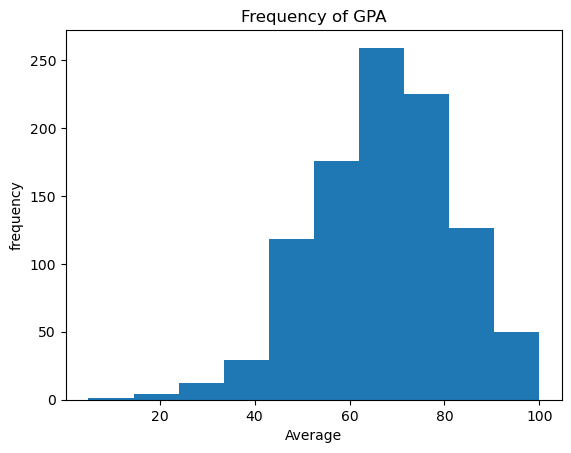

In [13]:
plt.hist(df['average'])
plt.xlabel('Average')
plt.ylabel('frequency')
plt.title('Frequency of GPA')
plt.show()

The GPA with the most counts is 0.00.

In [14]:
print(df['parental_education'].unique())

["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']


In [15]:
print(df['lunch'].unique())

['standard' 'free/reduced']


In [16]:
avg_bachelors_gpa = round(np.mean(df[df['parental_education']=="bachelor's degree"].GPA),2)
avg_some_college_gpa = round(np.mean(df[df['parental_education']=='some college'].GPA),2)
avg_masters_gpa = round(np.mean(df[df["parental_education"]=="master's degree"].GPA),2)
avg_associates_gpa = round(np.mean(df[df["parental_education"]=="associate's degree"].GPA),2)
avg_high_school_gpa = round(np.mean(df[df['parental_education']=='high school'].GPA),2)
avg_some_high_school_gpa = round(np.mean(df[df['parental_education']=='some high school'].GPA),2)

In [17]:
bachelors_subset = df[df['parental_education']=="bachelor's degree"]
some_college_gpa_subset = df[df['parental_education']=='some college']
masters_gpa_subset = df[df["parental_education"]=="master's degree"]
associates_gpa = df[df["parental_education"]=="associate's degree"]
high_school_gpa_subset = df[df['parental_education']=='high school']
some_high_school_gp_subset = df[df['parental_education']=='some high school']

In [18]:
print(df['test_prep'].unique())

['none' 'completed']


In [19]:

def parent_ed_encode(level):
    if level == 'some high school':
        return 0
    elif level == 'high school':
        return 1
    elif level == "associate's degree":
        return 2
    elif level == "master's degree":
        return 5
    elif level == 'some college':
        return 3
    elif level == "bachelor's degree":
        return 4

In [20]:
parent_ed_list = []
for value in df.parental_education:
    parent_ed_list.append(parent_ed_encode(value))
df['parental_education_encoded'] = parent_ed_list

In [21]:
df

,gender,race/ethnicity,parental_education,lunch,test_prep,math_score,reading_score,writing_score,GPA,average,parental_education_encoded
0,female,group B,bachelor's degree,standard,none,72,72,74,1.78,73.0,4
1,female,group C,some college,standard,completed,69,90,88,2.78,78.5,3
2,female,group B,master's degree,standard,none,90,95,93,3.89,91.5,5
3,male,group A,associate's degree,free/reduced,none,47,57,44,0.00,45.5,2
4,male,group C,some college,standard,none,76,78,75,2.11,75.5,3
...,...,...,...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95,3.78,91.5,5
996,male,group C,high school,free/reduced,none,62,55,55,0.00,58.5,1
997,female,group C,high school,free/reduced,completed,59,71,65,0.89,62.0,1
998,female,group D,some college,standard,completed,68,78,77,2.00,72.5,3


<Figure size 1000x600 with 0 Axes>

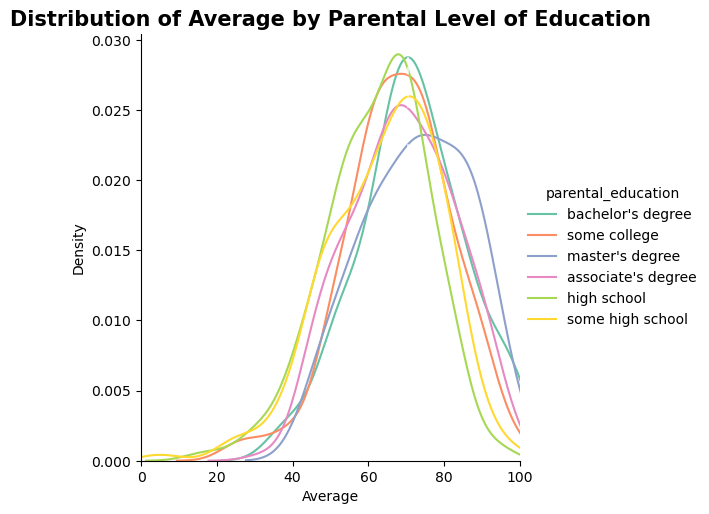

In [22]:
sns.set_palette("Set2")

plt.figure(figsize=(10, 6))


grid = sns.FacetGrid(df, hue="parental_education", height=5, xlim=(0, 100))
grid.map(sns.kdeplot, "average").add_legend()


for ax in grid.axes.flat:

    kde_data = ax.lines[0].get_data()
    x_values = kde_data[0]
    y_values = kde_data[1]


    median_value = x_values[np.argmax(y_values)]

    ax.vlines(x=median_value, ymin=0, ymax=np.max(y_values), color='white', linestyle='--', alpha=0.7, label='Median')

plt.title('Distribution of Average by Parental Level of Education', fontsize=15, fontweight='bold')
plt.xlabel('Average')
plt.ylabel('Density')

plt.show()

It appears that the highest average comes from students with parents having master's degrees and the lowest from parents with only high school degrees.

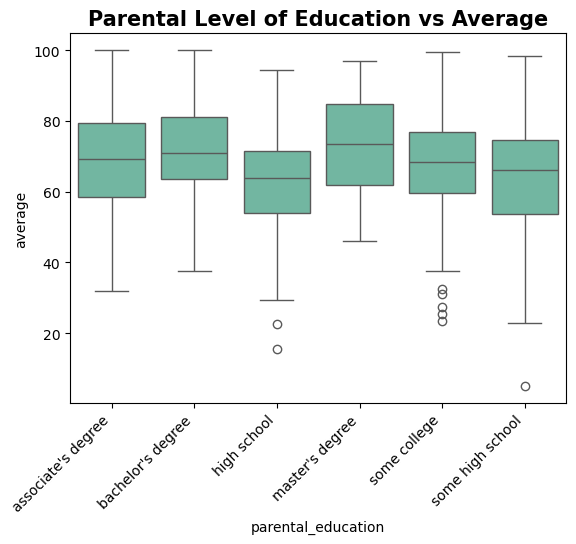

In [23]:
sns.boxplot(x="parental_education", y="average",
            data=df.sort_values("parental_education"))
plt.title('Parental Level of Education vs Average', fontsize=15, fontweight='bold')


plt.xticks(rotation=45, ha="right")

plt.show()

GPA median increases as follows: high school, some high school, some college, associate's degree, bachelor's degree, and master's degree.

In [24]:
df = df.drop('parental_education', axis=1)
df_encoded = pd.get_dummies(df, dtype=int)
df_encoded

,math_score,reading_score,writing_score,GPA,average,parental_education_encoded,gender_female,gender_male,race/ethnicity_group A,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,lunch_free/reduced,lunch_standard,test_prep_completed,test_prep_none
0,72,72,74,1.78,73.0,4,1,0,0,1,0,0,0,0,1,0,1
1,69,90,88,2.78,78.5,3,1,0,0,0,1,0,0,0,1,1,0
2,90,95,93,3.89,91.5,5,1,0,0,1,0,0,0,0,1,0,1
3,47,57,44,0.00,45.5,2,0,1,1,0,0,0,0,1,0,0,1
4,76,78,75,2.11,75.5,3,0,1,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,99,95,3.78,91.5,5,1,0,0,0,0,0,1,0,1,1,0
996,62,55,55,0.00,58.5,1,0,1,0,0,1,0,0,1,0,0,1
997,59,71,65,0.89,62.0,1,1,0,0,0,1,0,0,1,0,1,0
998,68,78,77,2.00,72.5,3,1,0,0,0,0,1,0,0,1,1,0


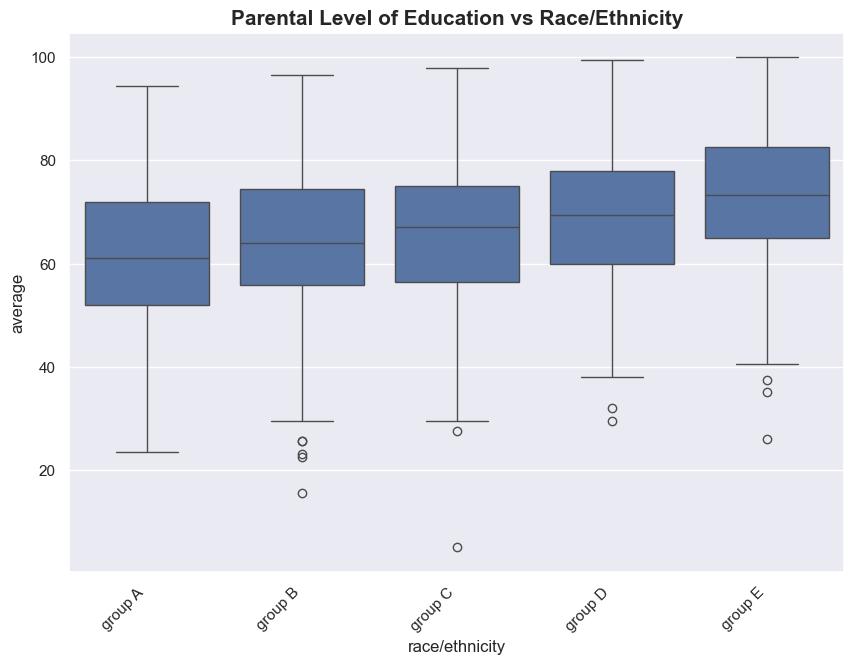

In [25]:
sns.set_theme(rc={'figure.figsize':(10,7)})
sns.boxplot(x="race/ethnicity", y="average",
            data=df.sort_values("race/ethnicity"))
plt.title('Parental Level of Education vs Race/Ethnicity', fontsize=15, fontweight='bold')


plt.xticks(rotation=45, ha="right")

plt.show()

<Axes: >

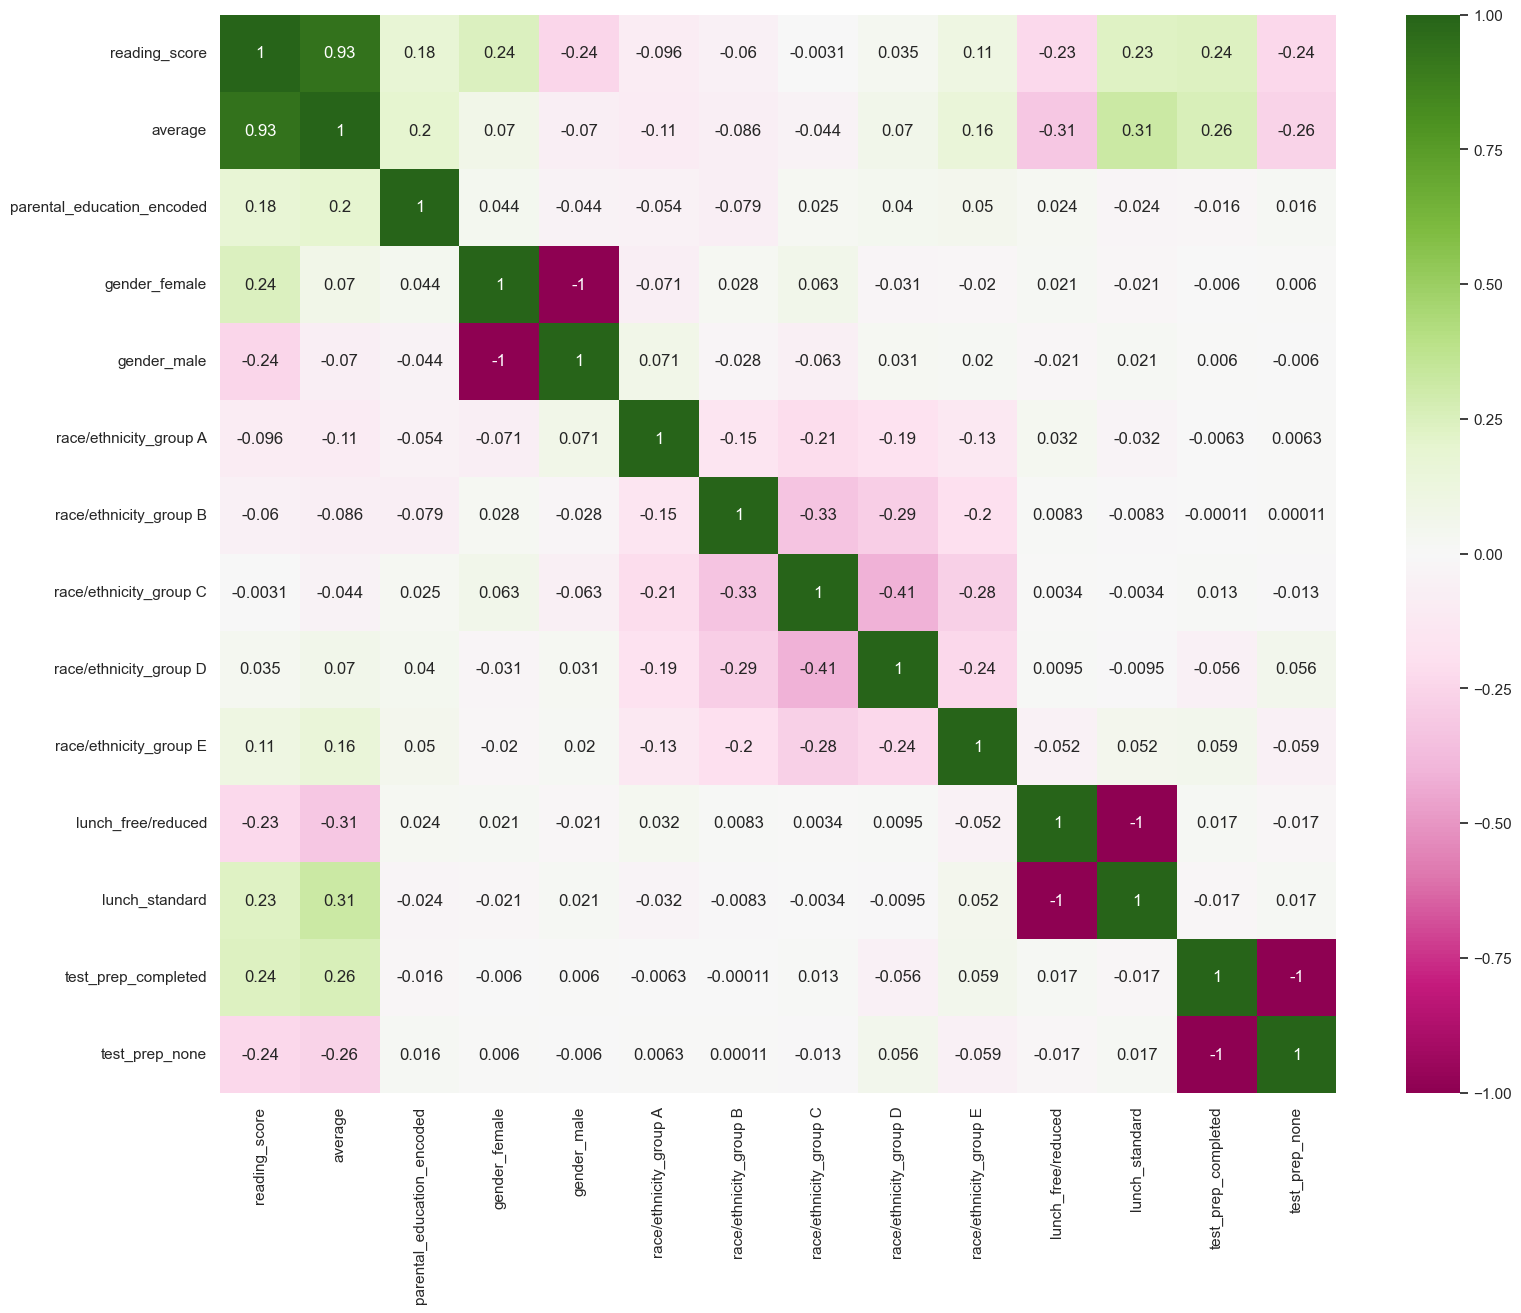

In [26]:
df_encoded = df_encoded.drop(columns = ['math_score', 'writing_score', 'GPA'])
correlation_matrix = df_encoded.corr()

sns.set_theme(rc={'figure.figsize':(18,14)})
sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns.values,
            yticklabels=correlation_matrix.columns.values,
            annot=True,
            cmap="PiYG")


Based on the correlation matrix reading scores are highly correlated with Average. Having standard lunch, completing test prep, and increasing parental education had a positive, but low correlation with average. Being a part of Race/Ethnicity Group A had a negative, very low correlation while Group E had a positive, very low correlation. 

In [27]:
df_encoded.columns

Index(['reading_score', 'average', 'parental_education_encoded',
       'gender_female', 'gender_male', 'race/ethnicity_group A',
       'race/ethnicity_group B', 'race/ethnicity_group C',
       'race/ethnicity_group D', 'race/ethnicity_group E',
       'lunch_free/reduced', 'lunch_standard', 'test_prep_completed',
       'test_prep_none'],
      dtype='object')

In [28]:
seed = 1
features = ['reading_score','gender_female','gender_male','race/ethnicity_group A', 'race/ethnicity_group B',
       'race/ethnicity_group C', 'race/ethnicity_group D',
       'race/ethnicity_group E', "parental_education_encoded", 
       'lunch_standard', 'lunch_free/reduced', 'test_prep_none', 'test_prep_completed']

X = df_encoded[features]
y = df_encoded.average
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)

In [29]:
RF_pipe = make_pipeline(
    StandardScaler(),
    RandomForestRegressor(random_state=47)
)


In [30]:
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
grid_params = {
        'randomforestregressor__n_estimators': n_est,
        'standardscaler': [StandardScaler(), None],
        
}
grid_params

{'randomforestregressor__n_estimators': [10,
  12,
  16,
  20,
  26,
  33,
  42,
  54,
  69,
  88,
  112,
  143,
  183,
  233,
  297,
  379,
  483,
  615,
  784,
  1000],
 'standardscaler': [StandardScaler(), None]}

In [31]:
rf_grid_cv = GridSearchCV(RF_pipe, param_grid=grid_params, cv=5)


In [32]:
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=47))]),
             param_grid={'randomforestregressor__n_estimators': [10, 12, 16, 20,
                                                                 26, 33, 42, 54,
                                                                 69, 88, 112,
                                                                 143, 183, 233,
                                                                 297, 379, 483,
                                                                 615, 784,
                                                                 1000],
                         'standardscaler': [StandardScaler(), None]})

In [33]:
rf_grid_cv.best_params_

{'randomforestregressor__n_estimators': 615, 'standardscaler': None}

In [34]:
rf_best_cv_results = cross_validate(rf_grid_cv.best_estimator_, X_train, y_train, cv=5, n_jobs = -1)
rf_best_scores = rf_best_cv_results['test_score']
rf_best_scores

array([0.85997954, 0.87434694, 0.87778265, 0.87541469, 0.87350805])

In [35]:
np.mean(rf_best_scores), np.std(rf_best_scores)


(0.8722063739115329, 0.006279489395355575)

In [36]:
scaler = StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [37]:
rf = RandomForestRegressor(n_estimators = 615)
regressor = rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

In [38]:
from sklearn.metrics import mean_squared_error as MSE
rmse_test = np.sqrt(MSE(y_test,y_pred))
print(rmse_test)

4.949818011666459


In [39]:
print(MSE(y_test,y_pred))

24.500698348617703


In [40]:
# Evaluating the model
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

R-squared: 0.8888019183731719


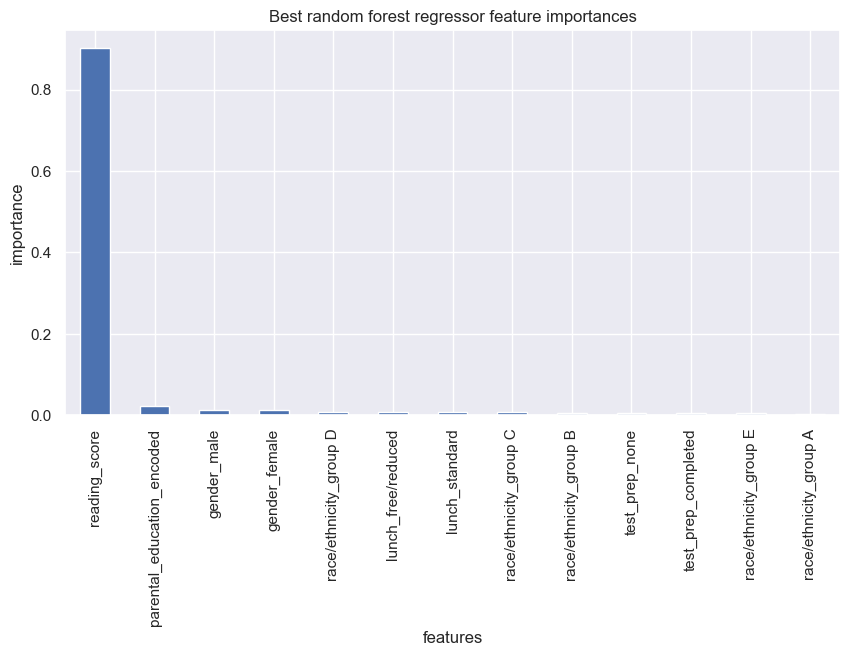

In [41]:
plt.subplots(figsize=(10, 5))

#assigning the `feature_importances_` attribute of 
#`rf_grid_cv.best_estimator_.named_steps.randomforestregressor` to the name `imps` to then
imps = rf_grid_cv.best_estimator_.named_steps.randomforestregressor.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train.columns).sort_values(ascending=False)

#Plot a barplot of the random forest's feature importances,
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [42]:
X = df_encoded[features]
y = df_encoded.average
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            random_state=2)

In [43]:
gb.fit(X_train,y_train)

# Predict test set labels
y_pred = gb.predict(X_test)

In [44]:

# Compute MSE
mse_test_gb = MSE(y_test,y_pred)

# Compute RMSE
rmse_test_gb = mse_test_gb **0.5

r2_gb = r2_score(y_test, y_pred)


# Print evaluation metrics
print('Test set RMSE of gb: {:.3f}'.format(rmse_test_gb))
print('Test set Mean Squared Error of gb: {:.3f}'.format(mse_test_gb))
print('Test set R-Squared: {:.3f}'.format(r2_gb))

Test set RMSE of gb: 4.793
Test set Mean Squared Error of gb: 22.971
Test set R-Squared: 0.896


In [45]:
top_features = ['reading_score','gender_female','gender_male', "parental_education_encoded"]
X = df_encoded[top_features]
y = df_encoded.average
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)

In [46]:
scaler = StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [47]:
rf = RandomForestRegressor(n_estimators = 615)
regressor = rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)

In [48]:
rmse_test = np.sqrt(MSE(y_test,y_pred))
mse_test_rf_top = MSE(y_test,y_pred)
print('Test set RMSE of Random Forest with Top Predictors: {:.3f}'.format(rmse_test))
print('Test set Mean Squared Error of Random Forest with Top Predictors: {:.3f}'.format(mse_test_rf_top))
r2 = r2_score(y_test, y_pred)
print(f'Test set R2 of Random Forest with Top Predictors: {r2}')

Test set RMSE of Random Forest with Top Predictors: 5.550
Test set Mean Squared Error of Random Forest with Top Predictors: 30.805
Test set R2 of Random Forest with Top Predictors: 0.8601904053494656


In [49]:
X = df_encoded[top_features]
y = df_encoded.average
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4, 
            n_estimators=200,
            random_state=2)
gb.fit(X_train,y_train)

# Predict test set labels
y_pred = gb.predict(X_test)
# Compute MSE
mse_test_gb = MSE(y_test,y_pred)

# Compute RMSE
rmse_test_gb = mse_test_gb **0.5

r2_gb = r2_score(y_test, y_pred)


# Print evaluation metrics
print('Test set RMSE of gb with Top Predictors: {:.3f}'.format(rmse_test_gb))
print('Test set Mean Squared Error of gb with Top Predictors: {:.3f}'.format(mse_test_gb))
print('Test set R-Squared of gb with Top Predictors: {:.3f}'.format(r2_gb))

Test set RMSE of gb with Top Predictors: 5.308
Test set Mean Squared Error of gb with Top Predictors: 28.178
Test set R-Squared of gb with Top Predictors: 0.872
